In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold, train_test_split
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [4]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("data")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
lr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [5]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [6]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes, affine=False))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [7]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.9, gamma=0.9, dropout=0.5):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.output_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        # forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        # input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        # new_A = F.tanh(F.relu(new_A))
        new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [8]:
class Embedder(torch.nn.Module):
    def __init__(self, in_dim, hidden, out_dim):
        super().__init__()
        self.omega1 = nn.Parameter(torch.randn((hidden, in_dim), device=DEVICE))
        self.beta1 = nn.Parameter(torch.zeros((hidden, 1), device=DEVICE))
        self.omega2 = nn.Parameter(torch.randn((out_dim, hidden), device=DEVICE))
        self.beta2 = nn.Parameter(torch.zeros((out_dim, 1), device=DEVICE))

    def forward(self, A):
        X = F.elu(self.beta1 + self.omega1 @ A)
        X = F.elu(self.beta2 + self.omega2 @ X)
        
        return torch.transpose(X,-1,-2)


In [10]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls, embedding_dims_ls=None):
        super().__init__()

        self.has_embedding_layer = False
        if embedding_dims_ls:
            self.has_embedding_layer = True
            assert len(embedding_dims_ls) == 3, 'Embedding dim list must be exactly 3'
            assert channels_ls[0] == embedding_dims_ls[-1], f'Last embedding dim must match first channel dim. Received {channels_ls[0]} and {embedding_dims_ls[-1]}'
            self.embedder = Embedder(embedding_dims_ls[0], embedding_dims_ls[1], embedding_dims_ls[2])

        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [11]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [23]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [22]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls,  gamma, epoch, a=0.5, b=1, c=0.2):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)

    alpha = (1 - np.exp(-c * epoch)) * (a - b) + b #modified

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss * (gamma ** 2)
    return total_loss

def l1_regularization_loss(models, l1_lambda):
    l1_reg_loss = torch.Tensor([0]).to(DEVICE)
    for model in models:
        all_params = torch.cat([p.view(-1) for p in model.parameters()])
        l1_reg_loss = l1_reg_loss + l1_lambda * torch.norm(all_params, 1)
    return l1_reg_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss
    
def reconstruction_loss_fn(gt_adj, pred_adj):
    l1_loss_fn = nn.L1Loss()
    return l1_loss_fn(gt_adj, pred_adj)

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [24]:
# trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=16)

train_idx, val_idx = train_test_split(list(range(len(lr_train))), test_size=0.2, shuffle=True, random_state=99)
trainloader = DataLoader(list(zip(lr_X_dim1[train_idx], lr_X_dim3[train_idx], lr_train[train_idx], hr_X_dim1[train_idx], hr_X_dim3[train_idx], hr_train[train_idx])), shuffle=True, batch_size=16)
valloader = DataLoader(list(zip(lr_X_dim1[val_idx], lr_X_dim3[val_idx], lr_train[val_idx], hr_train[val_idx])), shuffle=True, batch_size=16)


testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)


In [38]:
from torch.optim.lr_scheduler import MultiStepLR
dim_steps = generate_steps(num_steps=5)
channels_ls = [32, 64]
embedding_dims_ls_up = [160,64,32]
embedding_dims_ls_down = [268,64,32]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls, embedding_dims_ls_up).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls, embedding_dims_ls_down).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001)
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001)
reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.001)
up_scheduler = MultiStepLR(up_optimizer, milestones=[75, 200], gamma=0.1)
down_scheduler = MultiStepLR(down_optimizer, milestones=[75, 200], gamma=0.1)
recon_scheduler = MultiStepLR(reconstruction_optimizer, milestones=[75, 200], gamma=0.1)


sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


2456912

In [39]:
def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, valloader=None, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[], 'val_up_end_mae':[]}


    # gamma = 1 
    l1_lambda = 0.000001 # for L1 regularization
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
        reconstruction_losses = []

        up_changer.train()
        down_changer.train()   
            

        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader, desc=f'Epoch {epoch} Train'):

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_loss = down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1]) + l1_regularization_loss([down_changer], l1_lambda)
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_loss = up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], gamma=1, epoch=epoch) + l1_regularization_loss([up_changer], l1_lambda)
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)

            reconstruction_optimizer.zero_grad()

            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_end)[-1]
            torch.cuda.empty_cache()

            reconstruction_loss = reconstruction_loss_fn(up_adj_end, adj_hr.to(DEVICE)) + l1_regularization_loss([up_changer, down_changer], l1_lambda) / 2
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

        
            reconstruction_losses.append(reconstruction_loss.detach().item())
            del reconstruction_loss
            torch.cuda.empty_cache()

            gamma = 1 + down_final_mae_ls[-1] - up_final_mae_ls[-1] 
        
        if valloader is not None:
        
            val_up_final_mae_ls = []
        
            for X_lr, Y_lr, adj_lr, adj_hr in tqdm(valloader, desc=f'Epoch {epoch} Val'):
                up_changer.eval()
        
                freeze_model(up_changer)
        
                up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
                torch.cuda.empty_cache()
                val_up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), adj_hr.to(DEVICE)))
            
            epoch_val_up_final_mae = np.mean(val_up_final_mae_ls)
            loss_log['val_up_end_mae'].append(epoch_val_up_final_mae)

        
            

        up_scheduler.step()
        down_scheduler.step()
        recon_scheduler.step()
        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_reconstruction_loss = np.mean(reconstruction_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        if (epoch + 1) % 5 == 0:
            print(f'ep{epoch}: DOWN L={epoch_down_loss}, UP L={epoch_up_loss}, RC L={epoch_reconstruction_loss}, DOWN MAE={epoch_down_final_mae}, UP MAE={epoch_up_final_mae}, UP VAL MAE={epoch_val_up_final_mae}')


    return up_changer, down_changer, loss_log


In [40]:
# up_changer, down_changer, loss_log = train(300, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)
up_changer, down_changer, loss_log = train(200, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, valloader=valloader)

Epoch 4 Val: 100%|██████████| 3/3 [00:00<00:00, 23.27it/s]


ep4: DOWN L=0.8605373766687181, UP L=0.9098562863137987, RC L=0.9860564536518521, DOWN MAE=0.2739267415470547, UP MAE=0.29870717061890495, UP VAL MAE=0.3307959735393524


Epoch 9 Val: 100%|██████████| 3/3 [00:00<00:00, 23.80it/s]


ep9: DOWN L=0.7788440982500712, UP L=0.8395965364244249, RC L=0.9114514787991842, DOWN MAE=0.2437134087085724, UP MAE=0.265655807322926, UP VAL MAE=0.25122570991516113


Epoch 14 Val: 100%|██████████| 3/3 [00:00<00:00, 23.80it/s]


ep14: DOWN L=0.7026527126630148, UP L=0.7692408164342245, RC L=0.8528717756271362, DOWN MAE=0.24171919292873806, UP MAE=0.2618626455465953, UP VAL MAE=0.258068710565567


Epoch 19 Val: 100%|██████████| 3/3 [00:00<00:00, 24.25it/s]


ep19: DOWN L=0.635836833053165, UP L=0.7037192781766256, RC L=0.7974471847216288, DOWN MAE=0.22553203337722355, UP MAE=0.2497793518834644, UP VAL MAE=0.28721699118614197


Epoch 24 Val: 100%|██████████| 3/3 [00:00<00:00, 21.45it/s]


ep24: DOWN L=0.5722911026742723, UP L=0.6380346351199679, RC L=0.7370950314733717, DOWN MAE=0.22049427198039162, UP MAE=0.24025883111688826, UP VAL MAE=0.23198671638965607


Epoch 29 Val: 100%|██████████| 3/3 [00:00<00:00, 21.11it/s]


ep29: DOWN L=0.5176252524058024, UP L=0.5783797303835551, RC L=0.6816121869617038, DOWN MAE=0.2189097801844279, UP MAE=0.2284724364678065, UP VAL MAE=0.24414906402428946


Epoch 34 Val: 100%|██████████| 3/3 [00:00<00:00, 24.28it/s]


ep34: DOWN L=0.45685313807593453, UP L=0.5135243932406107, RC L=0.6177739765908983, DOWN MAE=0.22126170661714342, UP MAE=0.21945572064982521, UP VAL MAE=0.2084610511859258


Epoch 39 Val: 100%|██████████| 3/3 [00:00<00:00, 24.76it/s]


ep39: DOWN L=0.40257038010491264, UP L=0.4497503207789527, RC L=0.5505922569168938, DOWN MAE=0.21393738355901507, UP MAE=0.19603284696737924, UP VAL MAE=0.1778399646282196


Epoch 44 Val: 100%|██████████| 3/3 [00:00<00:00, 22.22it/s]


ep44: DOWN L=0.34651333424780106, UP L=0.38671663734647965, RC L=0.4871066047085656, DOWN MAE=0.20412108302116394, UP MAE=0.1769183725118637, UP VAL MAE=0.16114183266957602


Epoch 49 Val: 100%|██████████| 3/3 [00:00<00:00, 22.31it/s]


ep49: DOWN L=0.2961930003431108, UP L=0.3307950728469425, RC L=0.4357099367512597, DOWN MAE=0.21320681936211056, UP MAE=0.17605305545859867, UP VAL MAE=0.1693601260582606


Epoch 54 Val: 100%|██████████| 3/3 [00:00<00:00, 22.12it/s]


ep54: DOWN L=0.24541835652457344, UP L=0.2758243812455071, RC L=0.38452129893832737, DOWN MAE=0.20398859679698944, UP MAE=0.16794737842347887, UP VAL MAE=0.14687784761190414


Epoch 59 Val: 100%|██████████| 3/3 [00:00<00:00, 22.06it/s]


ep59: DOWN L=0.21766097512510088, UP L=0.24868265125486586, RC L=0.35941754778226215, DOWN MAE=0.20903808540768093, UP MAE=0.17272724376784432, UP VAL MAE=0.1531592682003975


Epoch 64 Val: 100%|██████████| 3/3 [00:00<00:00, 20.10it/s]


ep64: DOWN L=0.1995046916935179, UP L=0.234010249376297, RC L=0.3453215758005778, DOWN MAE=0.20171420607301924, UP MAE=0.1693014850219091, UP VAL MAE=0.16674072543780008


Epoch 69 Val: 100%|██████████| 3/3 [00:00<00:00, 25.17it/s]


ep69: DOWN L=0.18568597237269083, UP L=0.22290443215105268, RC L=0.33381200830141705, DOWN MAE=0.20112349092960358, UP MAE=0.16528315511014727, UP VAL MAE=0.1786885211865107


Epoch 74 Val: 100%|██████████| 3/3 [00:00<00:00, 22.19it/s]


ep74: DOWN L=0.16943519314130148, UP L=0.2093359993563758, RC L=0.3186843428346846, DOWN MAE=0.20115622878074646, UP MAE=0.16336231927076975, UP VAL MAE=0.16459298133850098


Epoch 79 Val: 100%|██████████| 3/3 [00:00<00:00, 20.94it/s]


ep79: DOWN L=0.16631775928868187, UP L=0.20627263022793663, RC L=0.3165571226014031, DOWN MAE=0.20488657388422224, UP MAE=0.1656607985496521, UP VAL MAE=0.1613221069176992


Epoch 84 Val: 100%|██████████| 3/3 [00:00<00:00, 21.56it/s]


ep84: DOWN L=0.16485918892754448, UP L=0.20581841468811035, RC L=0.31523754861619735, DOWN MAE=0.2018403477138943, UP MAE=0.16778526537948185, UP VAL MAE=0.15846049785614014


Epoch 89 Val: 100%|██████████| 3/3 [00:00<00:00, 20.76it/s]


ep89: DOWN L=0.1634912970993254, UP L=0.20403790970643362, RC L=0.3141766091187795, DOWN MAE=0.20451724363697898, UP MAE=0.16495193706618416, UP VAL MAE=0.164437398314476


Epoch 94 Val: 100%|██████████| 3/3 [00:00<00:00, 21.17it/s]


ep94: DOWN L=0.16137995819250742, UP L=0.2020986858341429, RC L=0.3111589120493995, DOWN MAE=0.2001605663034651, UP MAE=0.16346864898999533, UP VAL MAE=0.14897812406222025


Epoch 99 Val: 100%|██████████| 3/3 [00:00<00:00, 21.76it/s]


ep99: DOWN L=0.16036198867691887, UP L=0.2016710274749332, RC L=0.31245066391097176, DOWN MAE=0.2023412154780494, UP MAE=0.16552499102221596, UP VAL MAE=0.15325561662515005


Epoch 104 Val: 100%|██████████| 3/3 [00:00<00:00, 22.31it/s]


ep104: DOWN L=0.15919512179162768, UP L=0.20017425384786394, RC L=0.3096061481369866, DOWN MAE=0.19974251257048714, UP MAE=0.16210444437132943, UP VAL MAE=0.14992203811804453


Epoch 109 Val: 100%|██████████| 3/3 [00:00<00:00, 21.92it/s]


ep109: DOWN L=0.15679512752426994, UP L=0.1984274966849221, RC L=0.3078845242659251, DOWN MAE=0.19828986956013572, UP MAE=0.16441179480817583, UP VAL MAE=0.17802049219608307


Epoch 114 Val: 100%|██████████| 3/3 [00:00<00:00, 19.16it/s]


ep114: DOWN L=0.1558423704571194, UP L=0.19756772617499033, RC L=0.30789756443765426, DOWN MAE=0.19946586092313132, UP MAE=0.16515092386139762, UP VAL MAE=0.1595389445622762


Epoch 119 Val: 100%|██████████| 3/3 [00:00<00:00, 21.37it/s]


ep119: DOWN L=0.1551149305370119, UP L=0.19655968579981062, RC L=0.3064676920572917, DOWN MAE=0.1949092364973492, UP MAE=0.1612934238380856, UP VAL MAE=0.15581354002157846


Epoch 124 Val: 100%|██████████| 3/3 [00:00<00:00, 22.32it/s]


ep124: DOWN L=0.15358027650250328, UP L=0.19578281044960022, RC L=0.3071574634975857, DOWN MAE=0.2049297508266237, UP MAE=0.16656099590990278, UP VAL MAE=0.14504478375116983


Epoch 129 Val: 100%|██████████| 3/3 [00:00<00:00, 21.66it/s]


ep129: DOWN L=0.1514911933077706, UP L=0.19383816917737326, RC L=0.3044365445772807, DOWN MAE=0.19192403058211008, UP MAE=0.15850859218173557, UP VAL MAE=0.16378903885682425


Epoch 134 Val: 100%|██████████| 3/3 [00:00<00:00, 21.57it/s]


ep134: DOWN L=0.15049750275082058, UP L=0.19334003660413954, RC L=0.3027966519196828, DOWN MAE=0.19581678013006845, UP MAE=0.1632631023724874, UP VAL MAE=0.15671279529730478


Epoch 139 Val: 100%|██████████| 3/3 [00:00<00:00, 21.67it/s]


ep139: DOWN L=0.14893448683950636, UP L=0.19173625111579895, RC L=0.30234799451298183, DOWN MAE=0.19418664938873714, UP MAE=0.16374110844400194, UP VAL MAE=0.14573213706413904


Epoch 144 Val: 100%|██████████| 3/3 [00:00<00:00, 22.08it/s]


ep144: DOWN L=0.146606488360299, UP L=0.1897728078895145, RC L=0.2993568943606483, DOWN MAE=0.19642649094263712, UP MAE=0.1625183125336965, UP VAL MAE=0.14527772615353265


Epoch 149 Val: 100%|██████████| 3/3 [00:00<00:00, 21.47it/s]


ep149: DOWN L=0.14604040483633676, UP L=0.18925016621748605, RC L=0.2987511952718099, DOWN MAE=0.19444216787815094, UP MAE=0.1637796229786343, UP VAL MAE=0.16105705002943674


Epoch 154 Val: 100%|██████████| 3/3 [00:00<00:00, 21.65it/s]


ep154: DOWN L=0.1439201252328025, UP L=0.18734657598866356, RC L=0.29707567890485126, DOWN MAE=0.19327235056294334, UP MAE=0.16116867628362444, UP VAL MAE=0.16360797981421152


Epoch 159 Val: 100%|██████████| 3/3 [00:00<00:00, 22.01it/s]


ep159: DOWN L=0.14245498345957863, UP L=0.18630221982796988, RC L=0.2954736517535316, DOWN MAE=0.19352056086063385, UP MAE=0.16038349767525992, UP VAL MAE=0.16481313606103262


Epoch 164 Val: 100%|██████████| 3/3 [00:00<00:00, 22.31it/s]


ep164: DOWN L=0.14053123692671457, UP L=0.18452258739206526, RC L=0.29451945092942977, DOWN MAE=0.19076764749156105, UP MAE=0.16395932767126295, UP VAL MAE=0.16734925905863443


Epoch 169 Val: 100%|██████████| 3/3 [00:00<00:00, 21.76it/s]


ep169: DOWN L=0.13973846203751034, UP L=0.18363024956650204, RC L=0.2926088472207387, DOWN MAE=0.19828247527281442, UP MAE=0.16288389099968803, UP VAL MAE=0.15870561202367148


Epoch 174 Val: 100%|██████████| 3/3 [00:00<00:00, 21.89it/s]


ep174: DOWN L=0.13768176237742105, UP L=0.18198603060510424, RC L=0.2908459934923384, DOWN MAE=0.18819285763634575, UP MAE=0.1577132691939672, UP VAL MAE=0.1652748386065165


Epoch 179 Val: 100%|██████████| 3/3 [00:00<00:00, 20.84it/s]


ep179: DOWN L=0.13759565353393555, UP L=0.18139408197667864, RC L=0.2919054494963752, DOWN MAE=0.19554477598932055, UP MAE=0.16067937016487122, UP VAL MAE=0.14845438549915949


Epoch 184 Val: 100%|██████████| 3/3 [00:00<00:00, 19.28it/s]


ep184: DOWN L=0.1348206251859665, UP L=0.17955387300915188, RC L=0.28831756777233547, DOWN MAE=0.198056783941057, UP MAE=0.16334397594134012, UP VAL MAE=0.16645283500353494


Epoch 189 Val: 100%|██████████| 3/3 [00:00<00:00, 21.28it/s]


ep189: DOWN L=0.1330784426795112, UP L=0.17820311254925197, RC L=0.28644143872790867, DOWN MAE=0.1909976816839642, UP MAE=0.16181046432918972, UP VAL MAE=0.16700669129689535


Epoch 194 Val: 100%|██████████| 3/3 [00:00<00:00, 19.85it/s]


ep194: DOWN L=0.13233266605271232, UP L=0.17777341769801247, RC L=0.2889016336864895, DOWN MAE=0.19030755592717064, UP MAE=0.16336198482248518, UP VAL MAE=0.1513053079446157


Epoch 199 Val: 100%|██████████| 3/3 [00:00<00:00, 20.85it/s]

ep199: DOWN L=0.1302003280984031, UP L=0.17618526021639505, RC L=0.2847087648179796, DOWN MAE=0.19514512519041696, UP MAE=0.16251875129010943, UP VAL MAE=0.15853710969289145


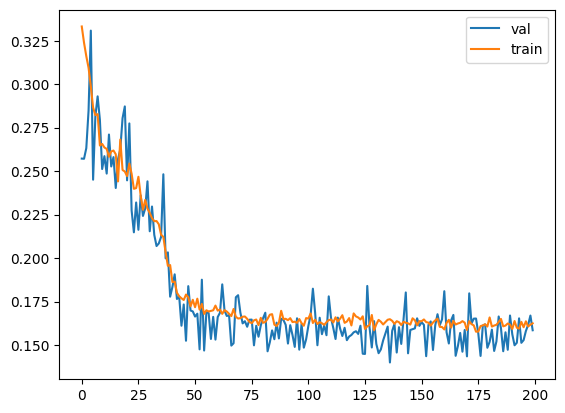

In [41]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['val_up_end_mae'])), loss_log['val_up_end_mae'], label='val')
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'], label='train')
plt.legend()
plt.show()

In [36]:
min(loss_log['up_end_mae'])

0.15036050644185808

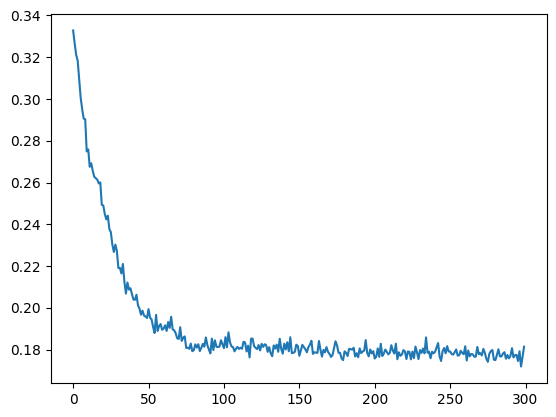

In [29]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [17]:
torch.save(up_changer.state_dict(), 'submission_files/tim_deep6_reconstr/up_changer300.pth')

In [16]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


In [18]:
torch.save(test_predictions, 'submission_files/tim_deep6_reconstr/tim_deep6_reconstr_pred300.pt')

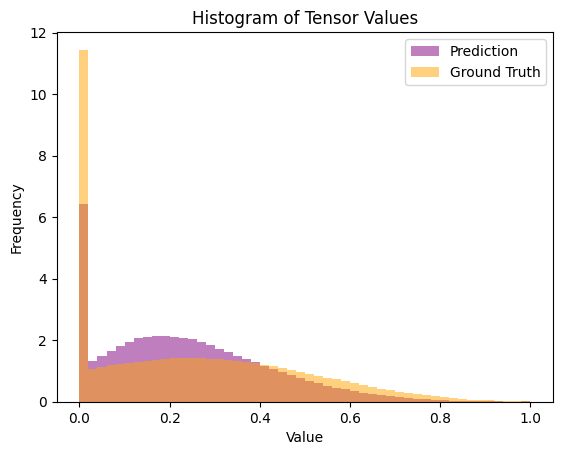

In [20]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

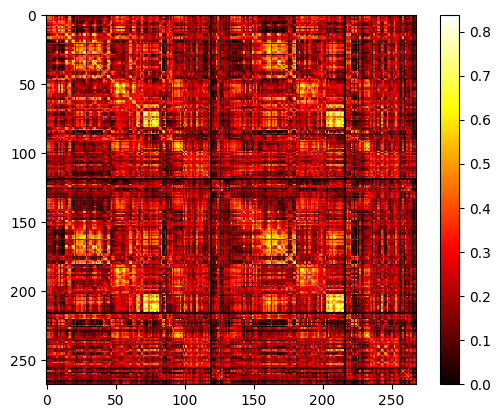

In [26]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [19]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep6_reconstr/tim_deep6_reconstr_pred300.csv')

# Cross Validation

In [11]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [12]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [15]:
cross_validate(5, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


epoch 0: down loss = 0.16564956307411194, up loss = 0.17200086265802383
Down end adj mae 0.28989551216363907
Up end adj mae 0.30541523545980453


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 1: down loss = 0.1615280844271183, up loss = 0.16848218068480492
Down end adj mae 0.2799903079867363
Up end adj mae 0.29920385777950287


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


epoch 2: down loss = 0.1559770405292511, up loss = 0.16499020531773567
Down end adj mae 0.27102500945329666
Up end adj mae 0.29710303246974945


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 3: down loss = 0.15054432675242424, up loss = 0.16159073635935783
Down end adj mae 0.2658237814903259
Up end adj mae 0.28980008512735367


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 4: down loss = 0.14580555632710457, up loss = 0.15819920599460602
Down end adj mae 0.24981610849499702
Up end adj mae 0.2819031700491905
begin validation


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
